# Time Series Model

In [1]:
## 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
df = pd.read_excel("Junior_Data_Analyst_Data.xlsx", header=2)

In [4]:
titles = [
    'Hour', 
    'Date/hour start', 
    'Solar electricity generation (kWh)',
    'Electricity usage (kWh)'
]

feature_keys = [
    'Hour', 
    'Date/hour start', 
    'Solar electricity generation (kWh)',
    'Electricity usage (kWh)']


In [5]:
split_fraction = 0.75
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 600
future = 100
learning_rate = 0.001
batch_size = 250
epochs = 20


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

train_split

6570

In [6]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 2, 3]]),
)
selected_features = [feature_keys[i] for i in [0, 2, 3]]
features = df[selected_features]
features.index = df['Date/hour start']
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]


The selected parameters are: Hour, Solar electricity generation (kWh), Electricity usage (kWh)


### Training dataset

In [7]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(3)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [8]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

### Validation dataset

In [9]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(3)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (250, 100, 3)
Target shape: (250, 1)


### Training

In [10]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 3)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4641 (18.13 KB)
Trainable params: 4641 (18.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Model Checkpoint

In [11]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=7)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 1.0537
Epoch 1: val_loss improved from inf to 0.32027, saving model to model_checkpoint.h5
24/24 [==============================] - 7s 150ms/step - loss: 1.0537 - val_loss: 0.3203
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 0.9725
Epoch 2: val_loss improved from 0.32027 to 0.31243, saving model to model_checkpoint.h5
24/24 [==============================] - 4s 156ms/step - loss: 0.9725 - val_loss: 0.3124
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 0.9007
Epoch 3: val_loss improved from 0.31243 to 0.29205, saving model to model_checkpoint.h5
24/24 [==============================] - 3s 131ms/step - loss: 0.9007 - val_loss: 0.2921
Epoch 4/20
24/24 [==============================] - ETA: 0s - loss: 0.8783
Epoch 4: val_loss did not improve from 0.29205
24/24 [==============================] - 3s 115ms/step - loss: 0.8783 - val_loss: 0.3025
Epoch 5/20
24/24 [===================

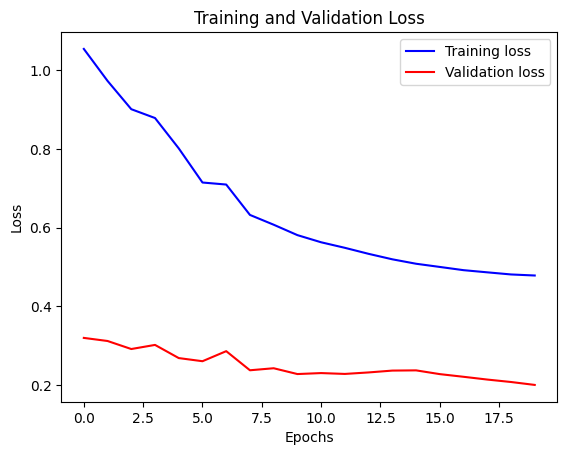

In [12]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

### Prediction

8/8 [==============================] - 1s 14ms/step


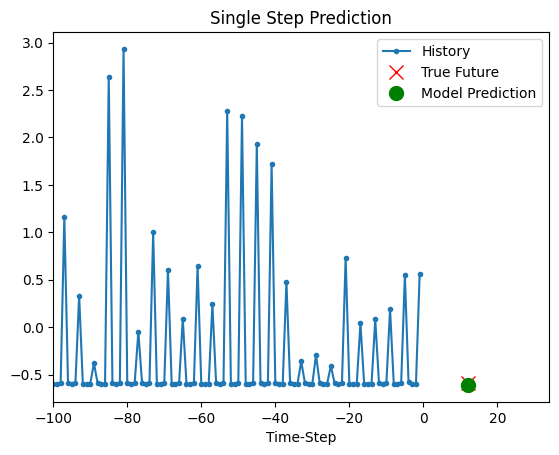

8/8 [==============================] - 0s 14ms/step


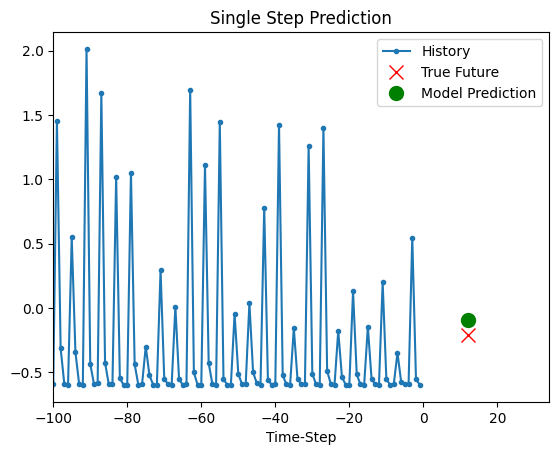

8/8 [==============================] - 0s 15ms/step


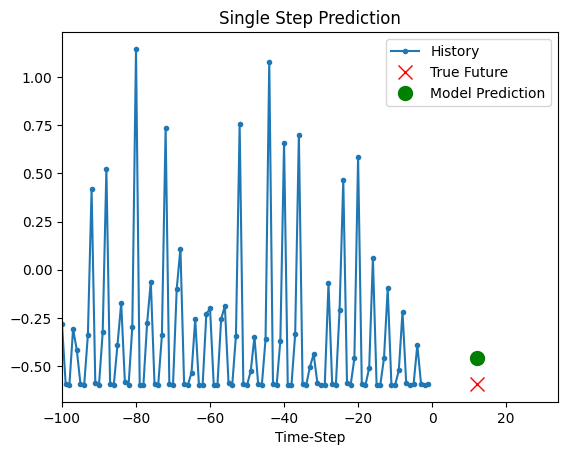

5/5 [==============================] - 0s 16ms/step


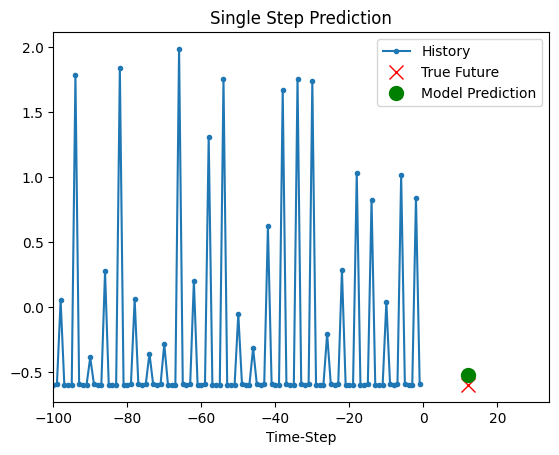

In [13]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )